In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
!gdown --id 1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
!gdown --id 1bs8PHTExPfItW636-HVRVYwjjPilQVgy

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
To: /content/id_map.parquet
100% 1.20M/1.20M [00:00<00:00, 75.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
To: /content/train.csv
42.9MB [00:00, 92.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bs8PHTExPfItW636-HVRVYwjjPilQVgy
To: /content/test.csv
24.8MB [00:00, 53.3MB/s]


In [ ]:
!pip install imbalanced-learn
!pip install scikit-learn==0.24
!pip install catboost
!pip install tldextract

     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 67.4 MB 65 kB/s 
     |████████████████████████████████| 87 kB 3.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import time
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier

import re
from wordcloud import WordCloud
from tldextract import extract
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

from imblearn.pipeline import Pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE

In [ ]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Support

In [ ]:
def dist_graph(data, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    alpha = 1e-3
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")
    if p < alpha:  # 
        print("The null hypothesis can be rejected")
        print("Oops, We shoukd try to transform the distribution!")
    else:
        print("The null hypothesis cannot be rejected")
        return data.loc[:, target_col], 1

    if p < alpha:
        data.loc[:, target_col+'_box'], lmbda = stats.boxcox(data.loc[:, target_col])
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(data.loc[:, target_col+'_box'], fit=norm, ax=axes[0]);
        res = stats.probplot(data.loc[:, target_col+'_box'], plot=axes[1])
        plt.tight_layout()
        plt.show()

        #skewness and kurtosis
        print("Skewness: %f" % data.loc[:, target_col+'_box'].skew())
        print("Kurtosis: %f" % data.loc[:, target_col+'_box'].kurt(), "\n")

        k2, p = stats.normaltest(data.loc[:, target_col+'_box'])
        alpha = 1e-3
        print("null hypothesis: x comes from a normal distribution")
        print(f"p_value = {p}, {k2}")
        if p < alpha:  # 
            print("The null hypothesis still can be rejected")
            print("But we did our best")
        else:
            print("The null hypothesis cannot be rejected now")
    return data.loc[:, target_col+'_box'], lmbda

In [ ]:
def webpage(data):
    for webpage_number in range(1,11):
        if webpage_number == 1:
            df = data[['session_id', f'webpage{webpage_number}', 'target']]
            df.columns = ['session_id', 'webpage', 'target']
        if webpage_number!=1:
            next = data[['session_id', f'webpage{webpage_number}', 'target']]
            next.columns = ['session_id', 'webpage', 'target']
            df = pd.concat([df, next], ignore_index=True)
    # check target share
    webpage_mean = df.groupby('webpage')['target'].mean()
    # check sum
    webpage_sum = df.groupby('webpage')['target'].sum()
    webpage = pd.merge(webpage_mean, webpage_sum, left_index=True, right_index=True)
    # share * sum
    webpage["target_value"] = webpage["target_x"] * webpage["target_y"]
    webpage.sort_values(inplace=True, by=["target_value"])
    webpage = webpage.loc[webpage["target_x"]>0]
    return webpage

def popular_webpages_features(data, webpages, list_of_quantiles):
    count = 0
    for quantile in list_of_quantiles:
        count += 1
        pages = webpages.loc[webpages["target_value"]>quantile].index
        data.loc[:, f'popular_pages_{count}'] = 0
        for col in [f"webpage{i}" for i in range(1,11)]:
            data.loc[data[col].isin(pages), f'popular_pages_{count}'] = 1
    return data

In [ ]:
def feature_extraction(data):

    data = data.assign(
        # session start time
        session_start=lambda x: x.filter(like='time').min(axis=1),
        # session end time
        session_end=lambda x: x.filter(like='time').max(axis=1),
        # session duration
        duration=lambda x: (x.session_end - x.session_start).dt.seconds,
        # start hour in a session
        start_hour=lambda x: x.session_start.apply(lambda x: x.hour).astype('category'),
        # day of week in a session
        weekday=lambda x: x.session_start.apply(lambda x: x.dayofweek).astype('category'),
        # day
        dayofyear=lambda x: x.session_start.apply(lambda x: x.dayofyear).astype('category'),

        # count_of_nans
        nans_count=lambda x: x.filter(like='webpage').isna().sum(axis=1),
        # nunique pages
        nunique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count)
        )

    data = data.reset_index().sort_values(['session_start', "session_id"], ignore_index=True)
    data.loc[data["duration"]==0, "duration"] = 0.01

    return data

In [ ]:
def remove_days(df, border=5):
    
    df = df.set_index('session_id')
    
    work_df = df.groupby('dayofyear')['popular_pages_1'].sum()
    good_days = work_df[(work_df > border) == True].index
    bad_days = work_df[(work_df <= border) == True].index
    good_session_id = df[df.dayofyear.isin(good_days)].index
    bad_session_id = df[df.dayofyear.isin(bad_days)].index
    
    bad_hours_array = np.array([3, 4, 6, 7, 10, 15, 16, 17, 18, 19])
    good_hours_array = np.array([5, 8, 9, 11, 12, 13, 14])
    good_hour_session_id = df[df.start_hour.isin(good_hours_array)].index
    bad_hour_session_id = df[df.start_hour.isin(bad_hours_array)].index

    good_session_id = np.intersect1d(good_session_id, good_hour_session_id)
    bad_session_id = np.unique(np.concatenate((bad_session_id, bad_hour_session_id), axis=None))
    
    df = df.loc[good_session_id]
    df = df.reset_index()
    
    return df, good_session_id, bad_session_id

# Preprocces

In [ ]:
OUTPUT_FOLDER = "/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/model_test"

In [ ]:
train = pd.read_csv("./train.csv", index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
x_test = pd.read_csv('./test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
x_test.reset_index(inplace=True)
id_map = pd.read_parquet("/content/id_map.parquet")

In [ ]:
# get user's webpages 
user_frame = train.loc[train["target"]==1].reset_index(drop=True)

array = np.array([])
for element in ["webpage"+str(x) for x in range(1,11)]:
    unique_array = user_frame.loc[:, element].unique()
    array = np.concatenate([array, unique_array])
array = {x for x in array if x==x}

id_map["target"] = 0
id_map.loc[id_map["id"].isin(array), "target"] = 1

# extract "sub-domain", "domain", "suf" from url of webpage
list_ = [list(extract(id_map.loc[i].webpage)) for i in id_map.index]
id_map.loc[:, ["sub","domain","suf"]] = list_

In [ ]:
train = feature_extraction(train)

# Weekday

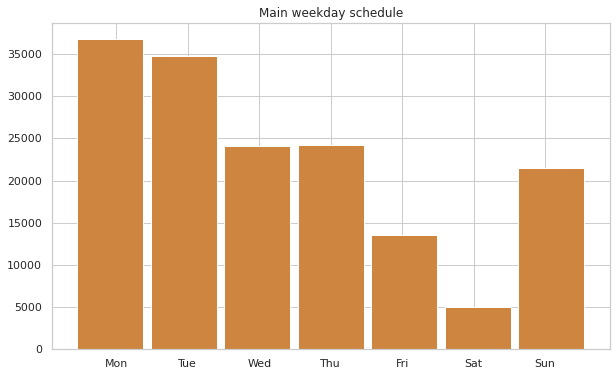

In [ ]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train.weekday, bins=7, rwidth=0.9, color='peru')
plt.xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)], labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Main weekday schedule')
plt.show()

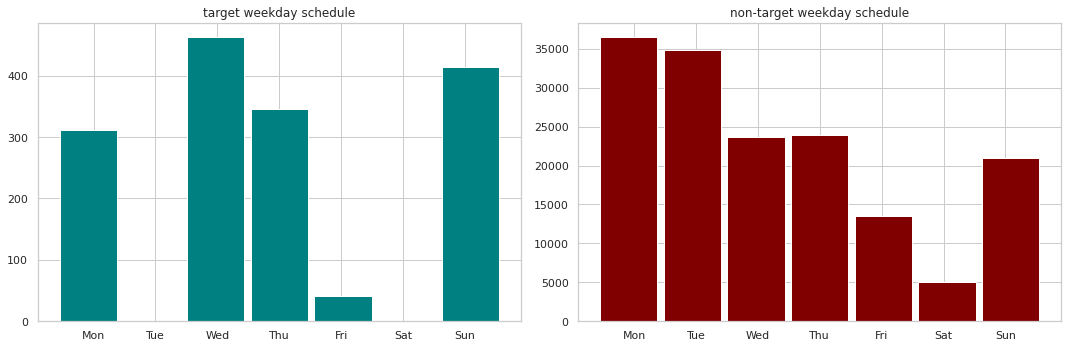

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train[train.target==1].weekday, bins=7, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train[train.target==0].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('target weekday schedule')
ax[1].title.set_text('non-target weekday schedule')
plt.tight_layout()
plt.show()

# Start_hour

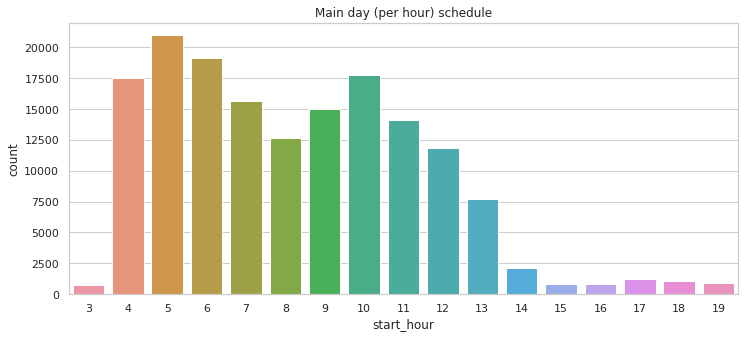

In [ ]:
fig = plt.figure(figsize=(12,5))
sns.countplot(x="start_hour", data=train)
plt.title('Main day (per hour) schedule')
plt.show()

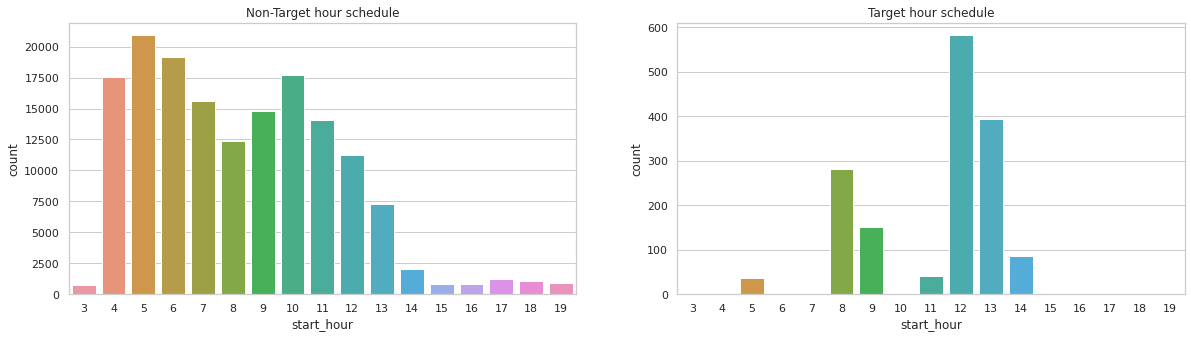

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x="start_hour", data=train.loc[train["target"]==1], ax=axes[1])
sns.countplot(x="start_hour", data=train.loc[train["target"]==0], ax=axes[0])
axes[1].set_title('Target hour schedule')
axes[0].set_title('Non-Target hour schedule')
plt.show()

Пользователь придерживается довольно строгого расписания. Нет наблюдений за ряд часов

# Duration

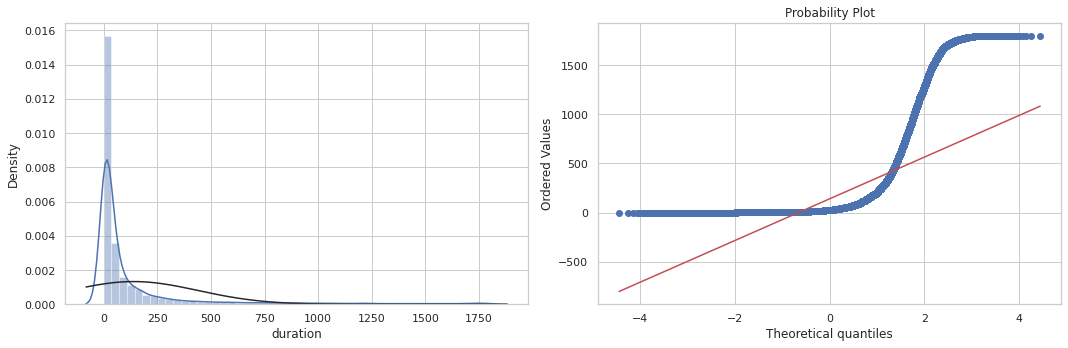

Skewness: 3.417982
Kurtosis: 12.211970 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 112242.39715218182
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


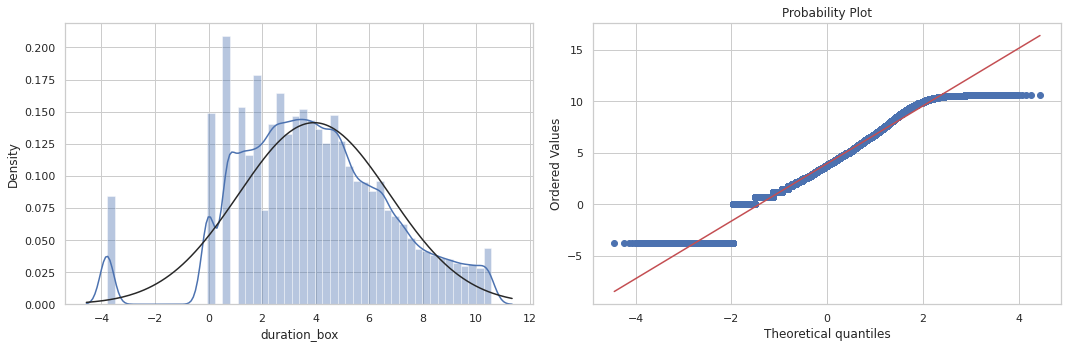

Skewness: 0.021876
Kurtosis: 0.218479 

null hypothesis: x comes from a normal distribution
p_value = 6.929955303287974e-60, 272.43850443240746
The null hypothesis still can be rejected
But we did our best


In [ ]:
train["duration"], b = dist_graph(data=train.copy(), target_col="duration")

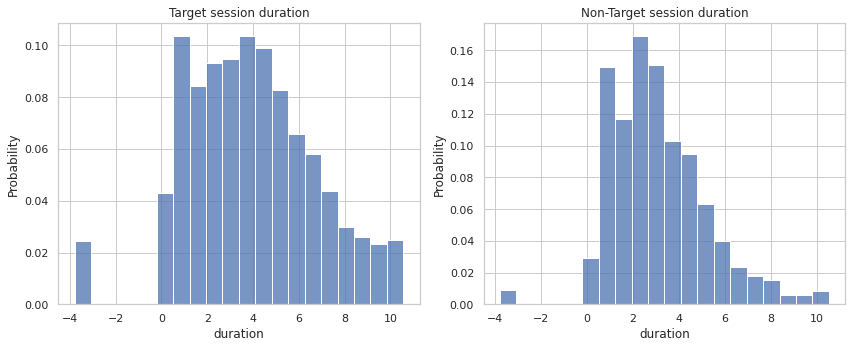

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(x="duration", data=train.loc[train["target"]==1, ["duration"]], stat="probability", bins=20, ax=axes[1])
sns.histplot(x="duration", data=train.loc[train["target"]==0, ["duration"]], stat="probability", bins=20, ax=axes[0])
axes[0].set_title('Target session duration')
axes[1].set_title('Non-Target session duration')
plt.tight_layout()
plt.show()

In [ ]:
sample1 = train.loc[train["target"] == 1, "duration"].values
sample2 = train.loc[train["target"] == 0, "duration"].values
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2)

KruskalResult(statistic=202.97277017932507, pvalue=4.6895395804321275e-46)

# Popular pages

In [ ]:
webpages = webpage(train)

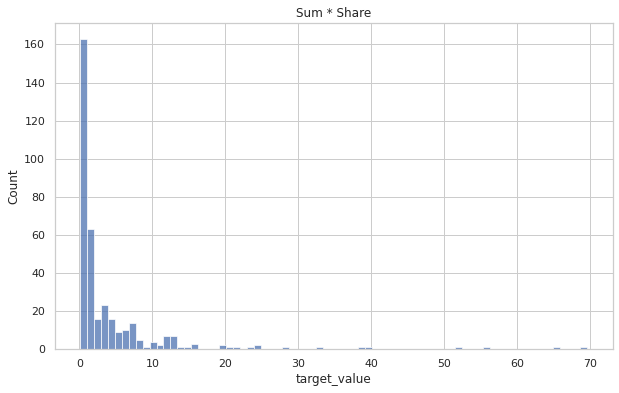

In [ ]:
ax, fig = plt.subplots(figsize=(10,6))
sns.histplot(x="target_value", data=webpages)
plt.title("Sum * Share")
plt.show()

In [ ]:
quantiles = webpages["target_value"].quantile([0.1, .5, .75, 0.9]).values

In [ ]:
train = popular_webpages_features(data=train.copy(), webpages=webpages, list_of_quantiles=quantiles)

# Remove useless observations

In [ ]:
train_part, good_ids_train, bad_ids_train = remove_days(train.copy(), border=5)

# Test preprocessing

In [ ]:
x_test = feature_extraction(x_test)

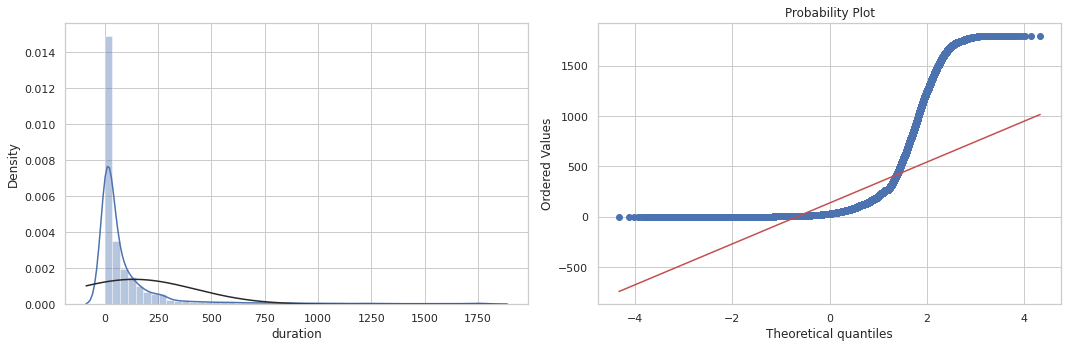

Skewness: 3.571544
Kurtosis: 13.555426 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 68393.53341678387
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


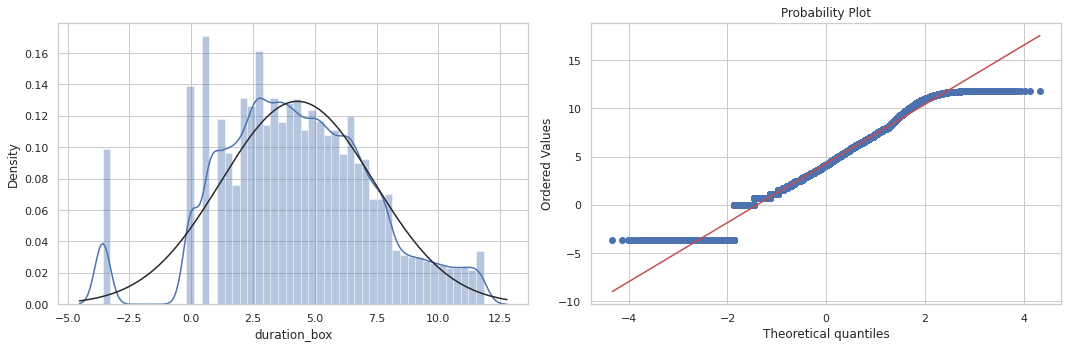

Skewness: 0.018164
Kurtosis: 0.152835 

null hypothesis: x comes from a normal distribution
p_value = 6.246834973603812e-19, 83.83408367125574
The null hypothesis still can be rejected
But we did our best


In [ ]:
x_test["duration"], b = dist_graph(data=x_test.copy(), target_col="duration")

In [ ]:
x_test = popular_webpages_features(data=x_test.copy(), webpages=webpages, list_of_quantiles=quantiles)
x_test_part, good_ids_test, bad_ids_test = remove_days(x_test.copy(), border=5)

# Predictions

In [ ]:
other_features_list = ["webpage"+str(i) for i in range(1,11)] + ["time"+str(i) for i in range(1,11)]
other_features = train_part.loc[:, other_features_list + ["session_id"]]
train_part.drop(columns=other_features_list+["session_start", "session_end", "dayofyear"], inplace=True)
train_part.set_index("session_id", inplace=True)
x_train_part, y_train_part = train_part.drop(columns=["target"]), train_part.loc[:, ["target"]]

In [ ]:
y_train = train.set_index("session_id").loc[:, ["target"]]

In [ ]:
other_features_list = ["webpage"+str(i) for i in range(1,11)] + ["time"+str(i) for i in range(1,11)]
other_features_test = x_test_part.loc[:, other_features_list + ["session_id"]]
x_test_part.drop(columns=other_features_list+["session_start", "session_end", "dayofyear", "index"], inplace=True)
x_test_part.set_index("session_id", inplace=True)

In [ ]:
x_train_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 159968
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   duration         82064 non-null  float64 
 1   start_hour       82064 non-null  category
 2   weekday          82064 non-null  category
 3   month            82064 non-null  category
 4   nans_count       82064 non-null  int64   
 5   nunique_pages    82064 non-null  float64 
 6   popular_pages_1  82064 non-null  int64   
 7   popular_pages_2  82064 non-null  int64   
 8   popular_pages_3  82064 non-null  int64   
 9   popular_pages_4  82064 non-null  int64   
dtypes: category(3), float64(2), int64(5)
memory usage: 5.2 MB


In [ ]:
model = CatBoostClassifier(learning_rate=0.03, depth=11, l2_leaf_reg=3, iterations=200, 
                           auto_class_weights = "Balanced", loss_function = "Logloss", 
                           random_state=42, cat_features=["start_hour", "weekday", "month"],
                           metric_period=15)

model.fit(x_train_part, y_train_part)

0:	learn: 0.6642389	total: 269ms	remaining: 53.6s
1:	learn: 0.6376133	total: 389ms	remaining: 38.5s
2:	learn: 0.6158080	total: 487ms	remaining: 32s
3:	learn: 0.5945511	total: 624ms	remaining: 30.6s
4:	learn: 0.5769785	total: 704ms	remaining: 27.5s
5:	learn: 0.5608676	total: 764ms	remaining: 24.7s
6:	learn: 0.5441030	total: 848ms	remaining: 23.4s
7:	learn: 0.5313400	total: 906ms	remaining: 21.7s
8:	learn: 0.5190343	total: 960ms	remaining: 20.4s
9:	learn: 0.5032197	total: 1.13s	remaining: 21.4s
10:	learn: 0.4945220	total: 1.19s	remaining: 20.4s
11:	learn: 0.4849677	total: 1.25s	remaining: 19.6s
12:	learn: 0.4650982	total: 1.44s	remaining: 20.6s
13:	learn: 0.4555519	total: 1.52s	remaining: 20.3s
14:	learn: 0.4478919	total: 1.58s	remaining: 19.5s
15:	learn: 0.4374152	total: 1.71s	remaining: 19.6s
16:	learn: 0.4283030	total: 1.78s	remaining: 19.1s
17:	learn: 0.4198254	total: 1.85s	remaining: 18.7s
18:	learn: 0.4127671	total: 1.92s	remaining: 18.3s
19:	learn: 0.4061518	total: 2s	remaining: 1

In [ ]:
# TEST PART
# predict data with Alice (DataFrame with good_sessions_id)
y_pred_prob_lg = model.predict_proba(x_test_part)[:,1]
final_df_test_start = pd.DataFrame(y_pred_prob_lg, columns = ['target'], index=good_ids_test)

# prepare data without Alice (DataFrame with bad_sessions_id filled by zeros)
empty_result = np.zeros((len(bad_ids_test),), dtype=int)
empty_df = pd.DataFrame(empty_result, columns = ['target'], index=bad_ids_test)

# concat two DataFrames
final_df_test = pd.concat([final_df_test_start, empty_df], axis=0)
y_pred = np.array(final_df_test.sort_index().target)

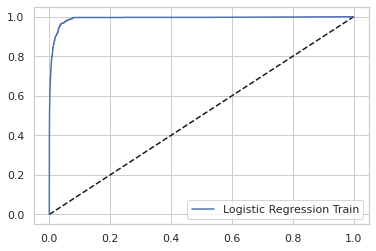

0.9911973898321869


In [ ]:
# TRAIN PART
# predict data with Alice (DataFrame with good_sessions_id)
y_pred_prob_lg_train = model.predict_proba(x_train_part)[:,1]
final_df_train_start = pd.DataFrame(y_pred_prob_lg_train, columns = ['preds'], index=good_ids_train)

# prepare data without Alice (DataFrame with bad_sessions_id filled by zeros)
empty_result = np.zeros((len(bad_ids_train),), dtype=int)
empty_df = pd.DataFrame(empty_result, columns = ['preds'], index=bad_ids_train)

# concat two DataFrames
final_df_train = pd.concat([final_df_train_start, empty_df], axis=0)
result_df = pd.merge(final_df_train, y_train, left_index=True, right_index=True).sort_index()

# plot the ROC Curve
fpr, tpr, trhesholds = roc_curve(result_df.iloc[:, 1].values, result_df.iloc[:, 0].values)
plt.plot([0, 1], [0, 1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression Train')
plt.legend()

plt.show()

print(roc_auc_score(result_df.iloc[:, 1].values, result_df.iloc[:, 0].values))

In [ ]:
def save_submission(pred, number):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/submissions_test/notebook_submission' + str(number) + '.csv')

In [ ]:
save_submission(y_pred, number=9)